## Idealized Surface Soil Moisture Bucket Model or SWAP (Soil, Water, Atmosphere and Plant) Model
Developed as coursework


### Motivation

Soil moisture plays a fundamental role in climate change projections as it is an important part of temperature and precipitation feedback (Seneviratne et al., 2010). Additionally, soil moisture deficits influence many aspects of drought including duration, spatial extent and magnitude. I have spent a lot of time reading about the relationship between soil moisture drought and climate change, a relationship that is largely discussed in the context of global circulation model output. My research is mainly focused on drought termination which in many drought events depends on the relationship between precipitation and soil-moisture holding capacity.  For this project, I would like to explore some of the underlying physical properties that dictate this relationship.

### Model

A soil moisture bucket model that can be adjusted to represent various climate regions based on the ‘first generation schemes’ discussed in Seneviratne et al., 2010. This model will include precipitation, evapotranspiration (defined as potential evapotranspiration multiplied by a limiting factor, β), and soil moisture holding capacity.Potential evapotranspiration can be calculated using the Thornthwaite equation or the Penman-Monteith equation.

![Simple sketch of the bucket model](figures/model_sketch.png)

### Governing Equation

In imagining the regions soil moisture as a large bucket, the governing equation can be simplified to: 

$\frac{dS}{dt} = P - E - R - D$

where $\frac{dS}{dt}$ is the change in surface soil water content (soil moisture), P is precipitation, E is evapotranspiration, R is runoff, and D is drainage. 

Precipitation is variable and pulled from an observational data product, CRU (more on that below). R and D are constants. 

Evapotranspiration is calculated and linked to soil mosture.  This is commonly done by calculating potential evapotranspiration ($E_{pot}$) scaled by a $\beta$ factor between the scenarios $\theta_{crit}$, when soil moisture content is high enough that it does not limit evapotranspiration, and $\theta_{wilt}$, when soil moisture is so low that evapotranspiration does not occur.

I'll be using [Thornthwaite equation](https://en.wikipedia.org/wiki/Potential_evaporation) to calculate potential evapotranspiration:

$E_{pot} = 16 (\frac{L}{12}(\frac{N}{30})(\frac{10 T_d}{I})^{\alpha}$ units: (mm/month)

where L is the average day length, N is the number of days, and $T_d$ is average daily temperature of the month being calculated. 

I is the heat index calculated as $\Sigma(\frac{T_{m_i}}{5})^{1.514}$, where $T_{m_i}$ is 12-month mean temperature.

$\alpha$ is $(6.75 *10^{-7})I^3 - (7.71 * 10^{-5})I^2 + (1.792 * 10^{-2})I + 0.49239$

Scaled by the $\beta$ factor:

$\beta = \frac{\theta - \theta_{wilt}}{\theta_{crit} - \theta_{wilt}}$ for $\theta_{wilt} \leq \theta \leq \theta_{crit}$


With this, I have slightly amended the governing equation to:

### $\frac{dS}{dt} = P - (\beta E_{pot}) - R - D$


n.b. if this proves do-able with the Thornwaite equation, I would like to try calculating $E_{pot}$ using the [Penman-Monteith equation](http://www.fao.org/3/x0490e/x0490e06.htm), which is generally considered to be a more robust method, but relies on additional variables that I'd need to find values for and/or additional data. 

Runoff = residual 


Ended up dropping the residual term for simplicity. This is not an uncommon decision if I'm just looking at soil moisture as those terms are more relevant to water management. (FIND RESEARCH TO BACK THIS UP?)


Final Equation: 

### $\frac{dS}{dt} = P - (\beta E_{pot})$


#### Some notes/research on $\beta$:

"Available water holding capacity (AWC) computed as the difference between field capacity (FC) and wilting point (WP) varies depending on the soil texture, (viz. sand, silt, and clay). In general, the sandy soils hold about 2.5 cm of water, silt has an AWC of 3.8 cm, and clay has a higher AWC of 5.3 cm of water per 30 cm soil column." (Sridhar et al. 2008)

### Research Question(s)

- How much precipitation is needed to end a soil moisture drought? 
- And how does that change if temperature increases (but precip holds steady)?
- How sensitive is the model to the  extremeness of preciptation? 

(make more specific & testable)

### Assumptions

This bucket model will likely overestimate real-life conditions because I’m not planning to adjust for plant physiology (and how plants respond to differing climate conditions) and assuming a single type of water storage (soil moisture). 

## TO DO & Questions:

- do bucket models usually use the outflow terms? (or can i just ignore them for this) 
- what would be a good estimate of those?
- make sure units all work
- get CRU evapotranspiration data?
- create all variables needed for governing equation


## New To DO:

- add units to xarray/netcdf stuff
- make evapotranspiration actual


## General Notes: 

this github has been helpful https://github.com/umn-earth-surface/bucket-hydrology/blob/master/bucket_hydrology_20191008.py 



### Works Cited

Chang, X., Wang, S., Gao, Z., Luo, Y., & Chen, H. (2019). Forecast of Daily Reference Evapotranspiration Using a Modified Daily Thornthwaite Equation and Temperature Forecasts†. Irrigation and Drainage, 68(2), 297–317. https://doi.org/10.1002/ird.2309

Seneviratne, S. I., Corti, T., Davin, E. L., Hirschi, M., Jaeger, E. B., Lehner, I., et al. (2010). Investigating soil moisture–climate interactions in a changing climate: A review. Earth-Science Reviews, 99(3), 125–161. https://doi.org/10.1016/j.earscirev.2010.02.004

Sridhar, V., Hubbard, K. G., You, J., & Hunt, E. D. (2008). Development of the Soil Moisture Index to Quantify Agricultural Drought and Its “User Friendliness” in Severity-Area-Duration Assessment. Journal of Hydrometeorology, 9(4), 660–676. https://doi.org/10.1175/2007JHM892.1

Thornthwaite, C. W. (1948). An Approach toward a Rational Classification of Climate. Geographical Review, 38(1), 55–94. https://doi.org/10.2307/210739

In [1]:
## Needed packages 
import numpy as np
import warnings
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display 
display.set_matplotlib_formats('retina')

In [2]:
warnings.filterwarnings('ignore')

## Dataset

CRU climate gridded time-series dataset

not currently using the newest version available on the website (https://crudata.uea.ac.uk/cru/data/hrg/)

using CRU TS v. 4.04 https://crudata.uea.ac.uk/cru/data/hrg/#legacy, released 24 April 2020, covers the period 1901-2019

Coverage: All land areas (excluding Antarctica) at 0.5° resolution

Variables: pre, tmp, tmx, tmn, dtr, vap, cld, wet, frs, pet

Reference: Harris et al. (2020) doi:10.1038/s41597-020-0453-3 

I'll be just looking at the Southwest United States within the coordinates:
- lat = (30,45)
- lon=(-125,-105)

In [3]:
# import data (local storage) 

# temperature
tmp_data = './data/tmp_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
tmp_ds = xr.open_dataset(tmp_data)

# precipitation
pre_data = './data/pre_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
pre_ds = xr.open_dataset(pre_data)

# evapotranspiration 
pet_data = './data/pet_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
pet_ds = xr.open_dataset(pet_data)

# temperature minimum
tmn_data = './data/tmn_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
tmn_ds = xr.open_dataset(tmn_data)

# temperature maximum
tmx_data = './data/tmx_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
tmx_ds = xr.open_dataset(tmx_data)

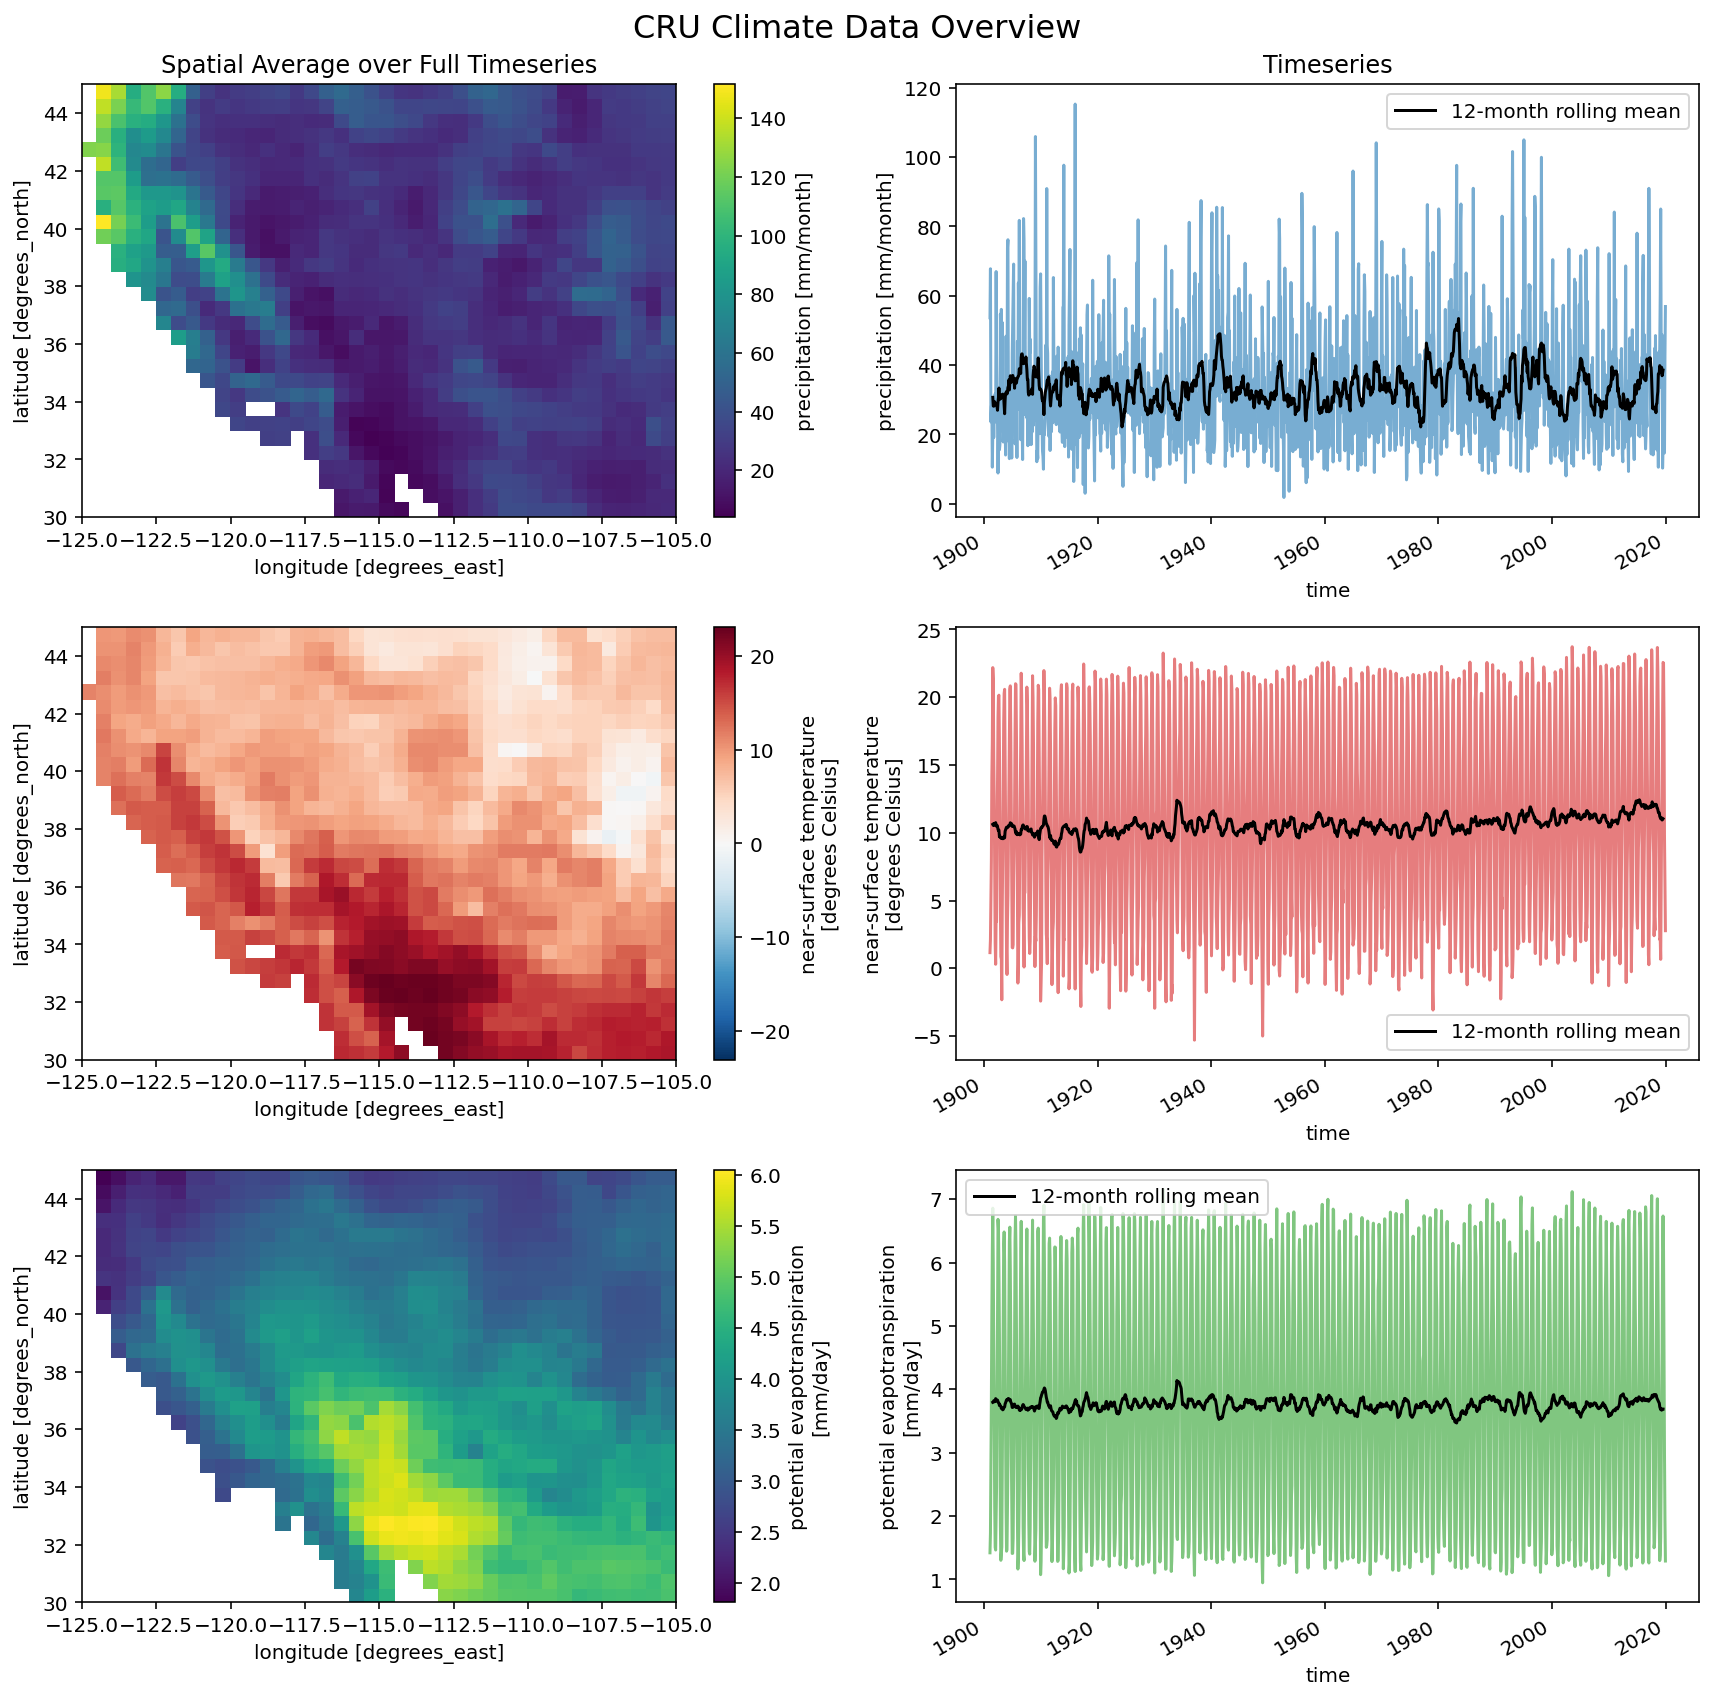

In [4]:
# basic data plotting

fig, ax = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 2, tight_layout = True)

# precipitation
pre_ds.mean('time', keep_attrs = True).pre.plot(ax = ax[0, 0])
pre_ds.mean(['lon', 'lat'], keep_attrs = True).pre.plot(ax = ax[0,1], color = 'tab:blue', alpha = 0.6)
pre_ds.pre.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[0,1], color = 'k', label = '12-month rolling mean')
ax[0, 0].set_title('Spatial Average over Full Timeseries')
ax[0,1].legend()


# temperature
tmp_ds.mean('time',  keep_attrs = True).tmp.plot(ax = ax[1, 0])
tmp_ds.mean(['lon', 'lat'], keep_attrs = True).tmp.plot(ax = ax[1,1], color = 'tab:red', alpha = 0.6)
tmp_ds.tmp.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[1,1], color = 'k', label = '12-month rolling mean')
ax[0,1].set_title('Timeseries')
ax[1,1].legend()


# evapotranspiration
pet_ds.mean('time',  keep_attrs = True).pet.plot(ax = ax[2,0])
pet_ds.mean(['lon', 'lat'], keep_attrs = True).pet.plot(ax = ax[2,1], color = 'tab:green', alpha = 0.6)
pet_ds.pet.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[2,1], color = 'k', label = '12-month rolling mean')
ax[2,1].legend()

plt.suptitle('CRU Climate Data Overview', fontsize = 16)

plt.tight_layout()

The CRU Potential Evapotranspiration Data is in mm/day, I need it in mm/month to match with precip, so I'll sum it by month

In [5]:
#TO DO


And now onto the bucket model:

In [19]:
class bucket:
    ''' one-box bucket model for soil moisture '''
    def __init__(self, tmp = tmp_ds.mean(['lon', 'lat'], keep_attrs = True).tmp, 
                 #tmx = tmx_ds.mean(['lon', 'lat'], keep_attrs = True).tmx, 
                 #tmn = tmn_ds.mean(['lon', 'lat'], keep_attrs = True).tmn, 
                 # resample PET data to be monthly -- nope the data is monthly, but in units mm/day
                 #pet = pet_ds.pet.resample(time="1MS").sum().mean(['lon', 'lat'])):
                 pet = pet_ds.mean(['lon', 'lat'], keep_attrs = True).pet):
        """
        
        PARAMETERS:
        precip: precipitation
        temp: temperature
        crit: critical threshold for soil moisture
        wilt: wilt threshold for soil moisture
        
        """
        
        #self.precip = precip
        self.tmp = tmp
        self.tmx = tmx
        self.tmn = tmn 
        self.pet = pet
        
        # TODO GO BACK AND FIX EVAPOTRANSPIRATION
        # Evapotranspiration 
        # Modified Thornwaithe EQ from Chang et al. 2019
        self.Chang_I = 41.47044637
        self.Chang_a_i = 6.75E-7*self.Chang_I**3 \
                         - 7.72E-5*self.Chang_I**2 \
                         + 1.7912E-2*self.Chang_I \
                         + 0.49239
        
        return None
    
    def bucket_integration(self, precipitation = pre_ds.mean(['lon', 'lat'], keep_attrs = True).pre, 
                           SM_ini = 1, 
                           date_ini = '1901-01-16',
                           date_end = '2019-12-16',
                           #time_ini = 0, time_end = 1000, 
                           tstep = 1, 
                           CRUpet = False,
                           tmx = tmx_ds.mean(['lon', 'lat'], keep_attrs = True).tmx, 
                           tmn = tmn_ds.mean(['lon', 'lat'], keep_attrs = True).tmn, 
                           crit = 150, wilt = 1 ): # need to figure out crit and wilt 
        """ governing equation 
        
        PARAMETERS:
        
        """
        
        self.date_ini = date_ini
        self.date_end = date_end
        self.tstep = tstep
        
        date_params ={'time':[date_ini, date_end]}
        
        self.precip = precipitation.sel(time=slice(*date_params['time']))
        
        self.crit = crit
        self.wilt = wilt
        
        self.tmx = tmx
        self.tmn = tmn 
        
        
        nsteps = int(len(pd.date_range(date_ini,date_end, freq="MS"))/tstep)
                
        SM = xr.Dataset(coords = {'time': (['time'],self.precip.time)}, 
                        data_vars = {'SM':(['time'],np.zeros(len((self.precip.time)))*np.nan)}, 
                        attrs = {'units': 'mm/month'})

        SM.SM[0] = SM_ini
        
        for t in range(0, nsteps-1):
        
            # bucket integration equation
            # with scaling (doesn't work yet)
            if CRUpet == False:
                SM.SM[t+1] =  self.precip[t] - self.scaling_factor(SM.SM[t]) * self.Epot(self.tmx[t], self.tmn[t], 12) 
                #SM.SM[t+1] =  self.precip[t] - self.scaling_factor(SM.SM[t]) * self.Epot(10, 2, 12) 
            
            # with CRU EPOT data
            if CRUpet == True: 
                # hackishly multiplying by 30 here.... 
                SM.SM[t+1] =  self.precip[t] - self.scaling_factor(SM.SM[t]) * 30 * self.pet[t]
            
            # soil moisture level cannot be negative, so if it is less than 0 set to 0
            # should this have any additional ramifications?
            if SM.SM[t+1] < 0:
                SM.SM[t+1] = 0
            
        self.SM = SM
        self.plot_timeseries()
        
            
        return self.SM
    
    
    def scaling_factor(self, theta):
        """ beta scaling factor for potential evapotransipration"""
        
        # wet regime
        if theta > self.crit:
            beta = 1
        
        # 
        if theta < self.wilt:
            beta = 0
        
        #
        else:
            beta = (theta - self.wilt)/(self.crit - self.wilt)
        return beta
        
    def Epot(self, Tmax, Tmin, photoperiod):
        """ calculation of potential evapotranspiration using modified monthly thorntwaite equation"""
        
        Teff = 0.5 * 0.69 * (3*Tmax - Tmin)
        C = photoperiod/360.


        self.E_pot = (C*(-415.85 + 32.24*Teff - 0.43*Teff**2) * (Teff >= 26) \
                    + 16.*C * (10.*Teff / self.Chang_I)**self.Chang_a_i \
                    * (Teff > 0) * (Teff < 26)) * 30
        
        return self.E_pot
        
    def plot_timeseries(self):
        """ plotting function """
        
        plt.figure(figsize=[10,8])
        self.SM.SM.plot(color = 'tab:brown')
        #plt.plot(self.time + self.time_offset, self.SM, color = 'tab:grey')
        plt.xlabel('years')
        plt.ylabel('soil moisture [mm/month]')
         
        return None

In [20]:
model = bucket()

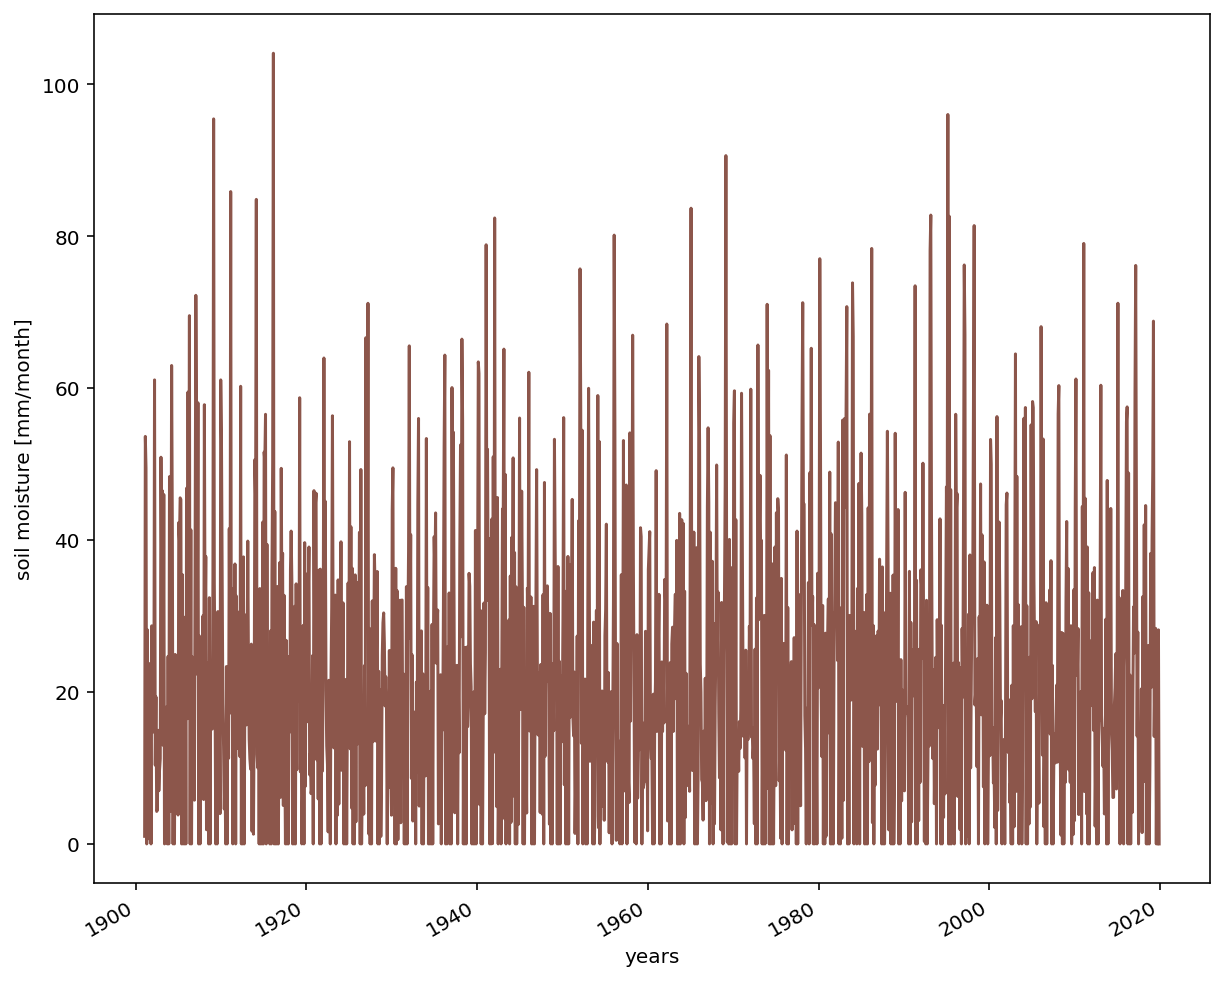

In [21]:
soil_moisture = model.bucket_integration(CRUpet = True)

In [22]:
soil_moisture.SM.mean()

<xarray.DataArray 'SM' ()>
array(22.12659061)

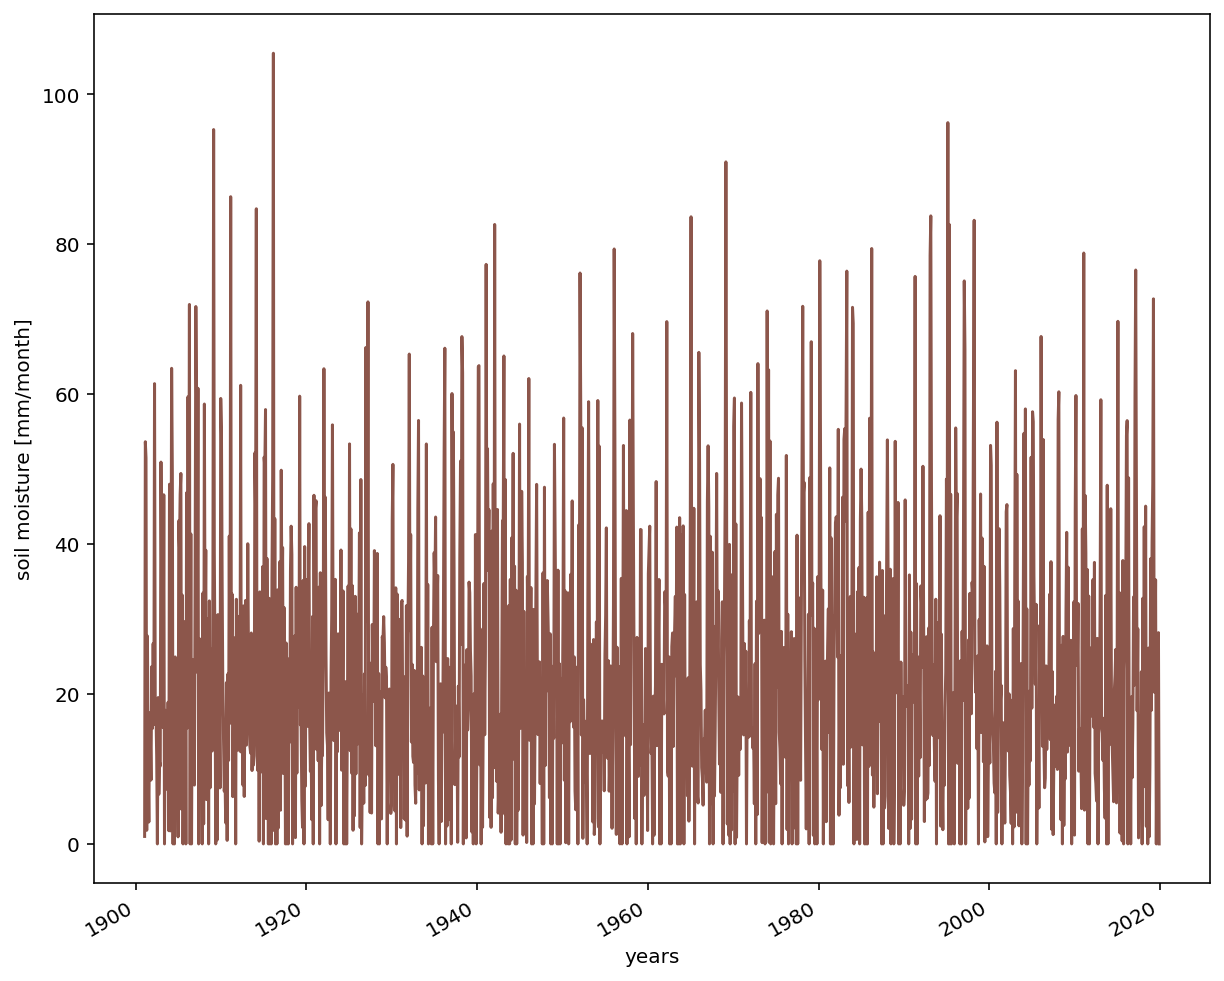

In [23]:
soil_moisture = model.bucket_integration(CRUpet = False)

In [24]:
soil_moisture.SM.mean()

<xarray.DataArray 'SM' ()>
array(22.78680222)

## Recent drought

Does this pic up the recent drought at all?

In [25]:
params = {'time':['2015-01','2019-12']}

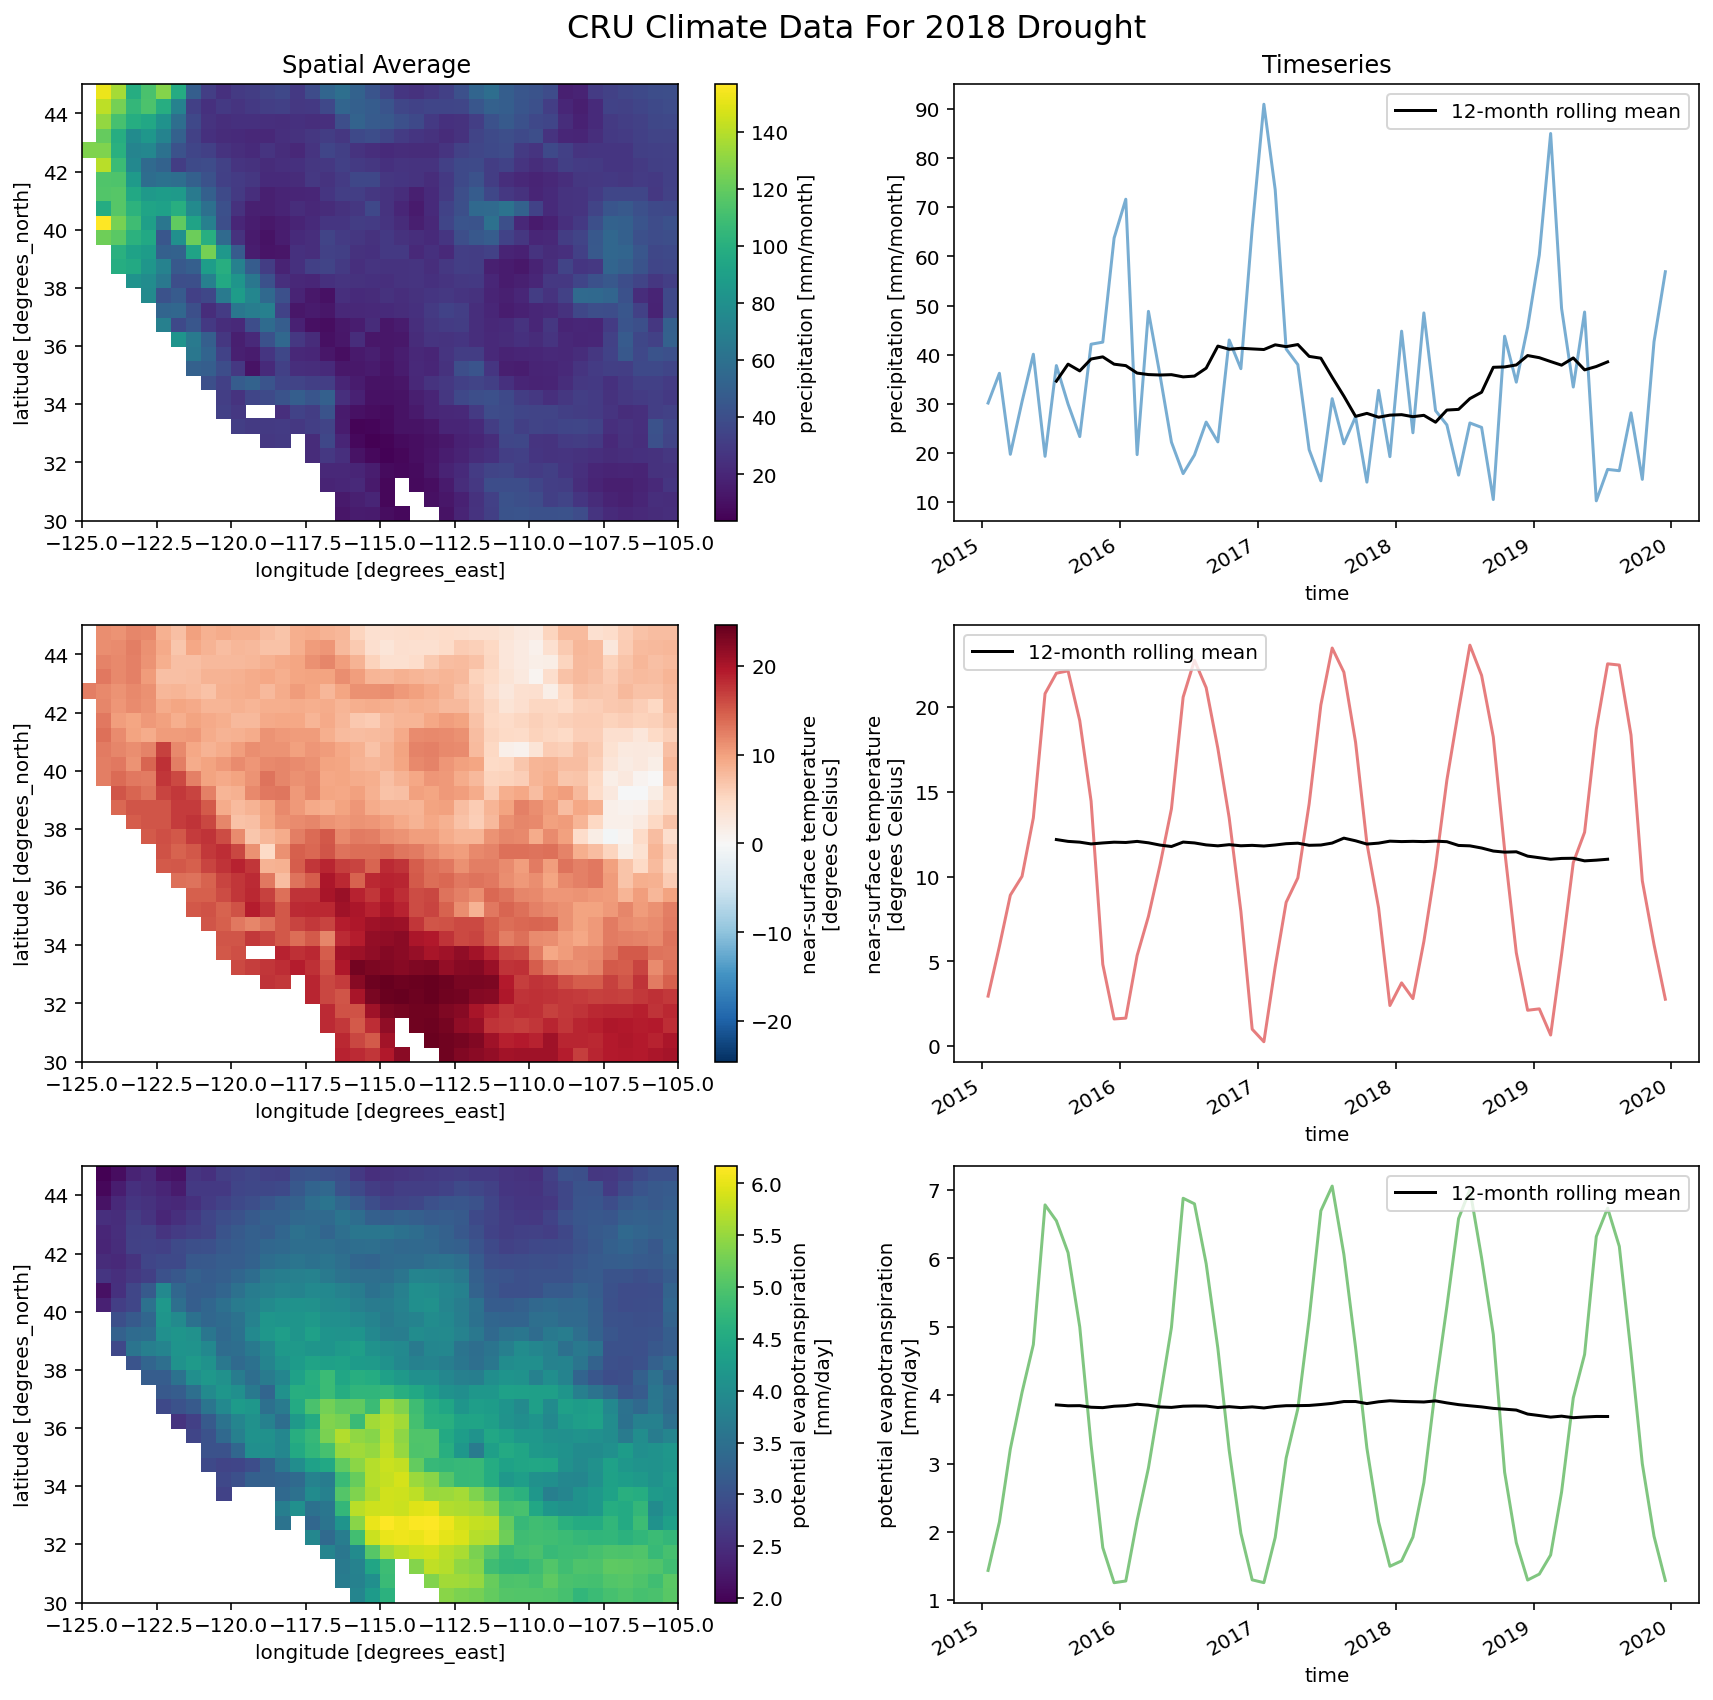

In [26]:
fig, ax = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 2, tight_layout = True)

# precipitation
pre_ds.sel(time=slice(*params['time'])).mean('time', keep_attrs = True).pre.plot(ax = ax[0, 0])
pre_ds.sel(time=slice(*params['time'])).mean(['lon', 'lat'], keep_attrs = True).pre.plot(ax = ax[0,1], color = 'tab:blue', alpha = 0.6)
pre_ds.sel(time=slice(*params['time'])).pre.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[0,1], color = 'k', label = '12-month rolling mean')
ax[0, 0].set_title('Spatial Average ')
ax[0,1].legend()


# temperature
tmp_ds.sel(time=slice(*params['time'])).mean('time',  keep_attrs = True).tmp.plot(ax = ax[1, 0])
tmp_ds.sel(time=slice(*params['time'])).mean(['lon', 'lat'], keep_attrs = True).tmp.plot(ax = ax[1,1], color = 'tab:red', alpha = 0.6)
tmp_ds.sel(time=slice(*params['time'])).tmp.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[1,1], color = 'k', label = '12-month rolling mean')
ax[0,1].set_title('Timeseries')
ax[1,1].legend()


# evapotranspiration
pet_ds.sel(time=slice(*params['time'])).mean('time',  keep_attrs = True).pet.plot(ax = ax[2,0])
pet_ds.sel(time=slice(*params['time'])).mean(['lon', 'lat'], keep_attrs = True).pet.plot(ax = ax[2,1], color = 'tab:green', alpha = 0.6)
pet_ds.sel(time=slice(*params['time'])).pet.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[2,1], color = 'k', label = '12-month rolling mean')
ax[2,1].legend()

plt.suptitle('CRU Climate Data For 2018 Drought', fontsize = 16)
plt.tight_layout()

## Model with CRUpet during 2018 drought:

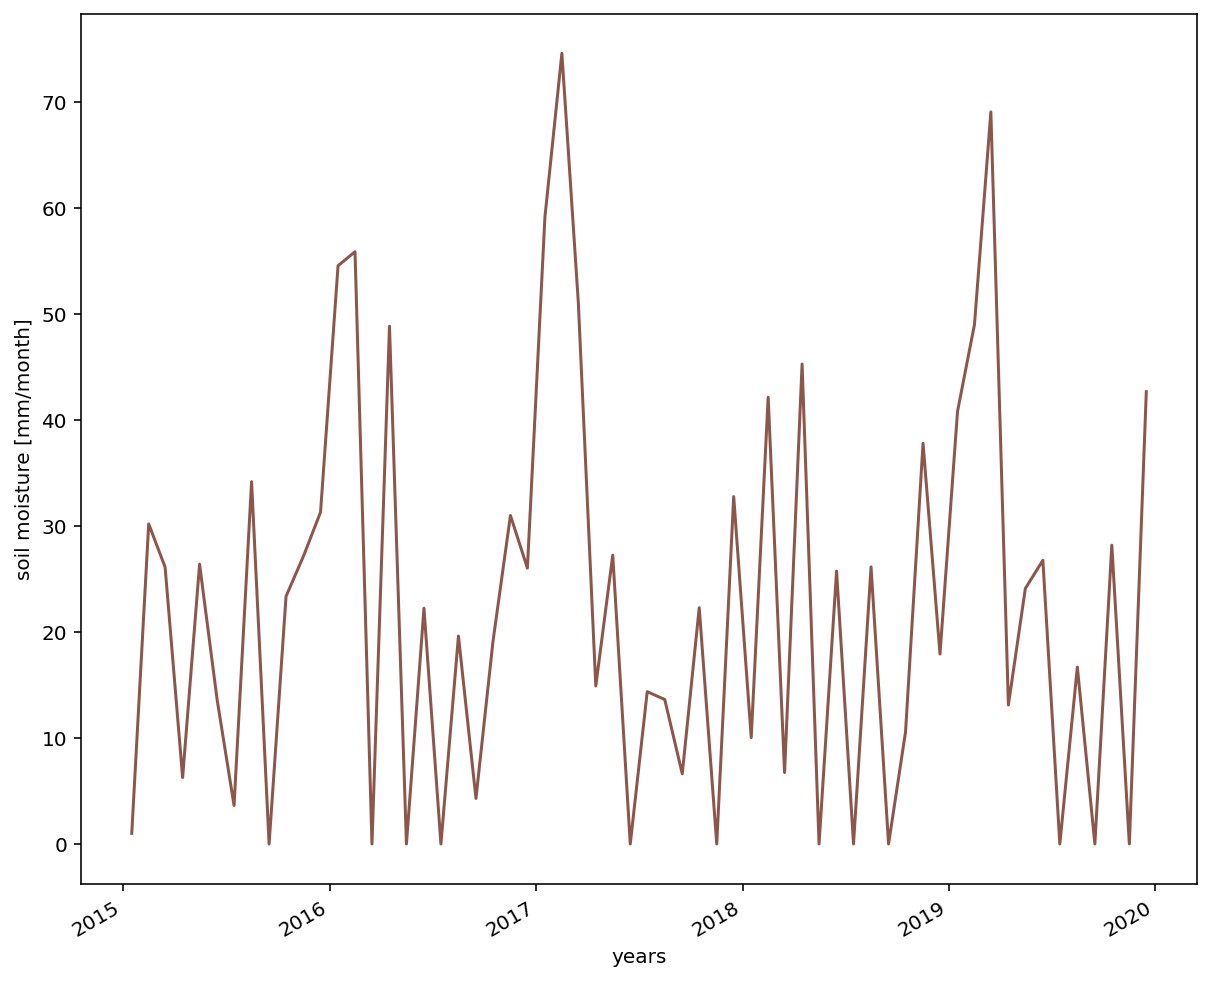

In [27]:
soil_moistureCRU = model.bucket_integration(CRUpet = True, date_ini = '2015-01', date_end = '2019-12')

## Model with simplified pet during 2018 drought:

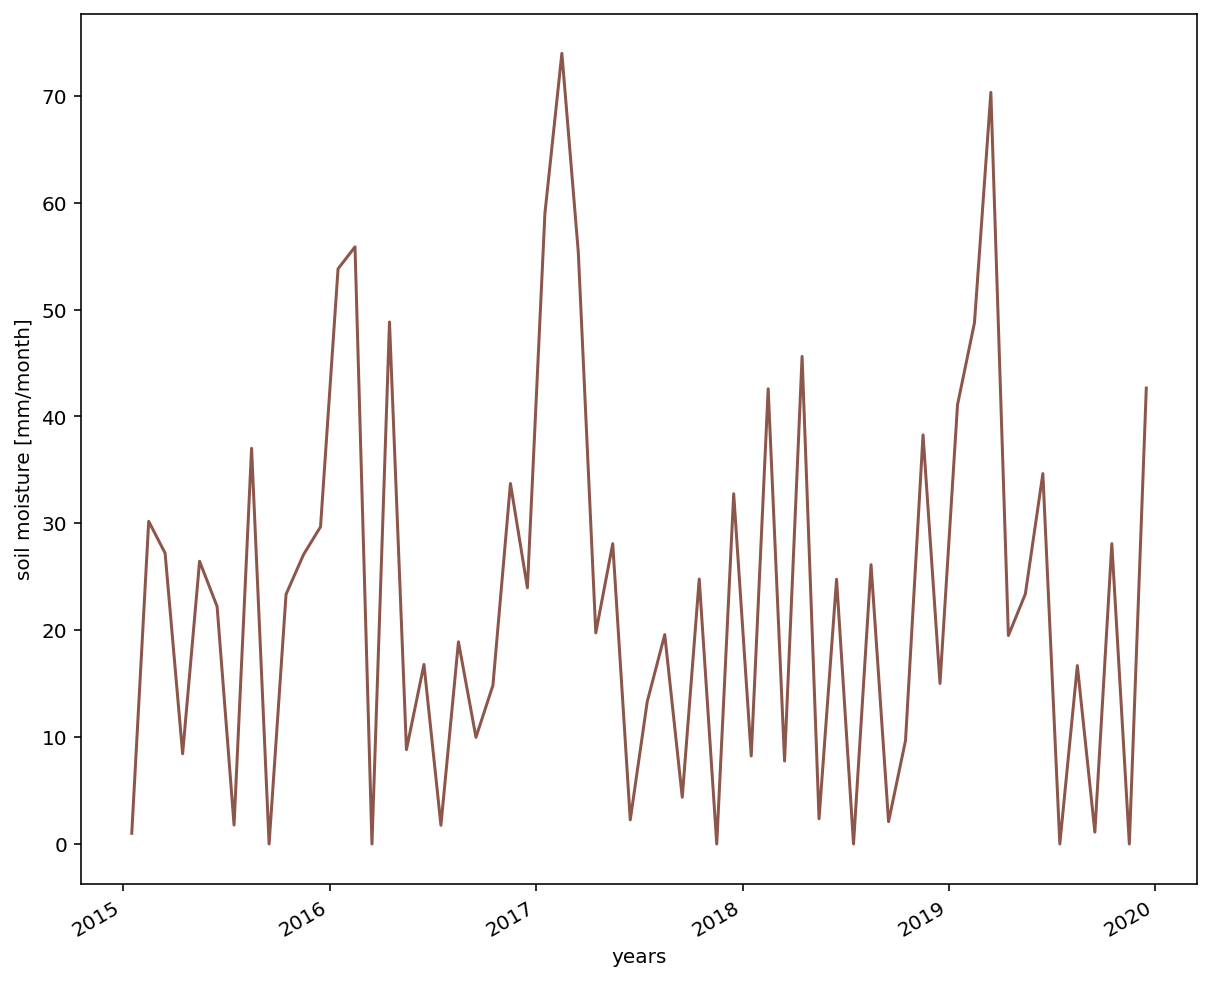

In [28]:
soil_moistureCALC = model.bucket_integration(CRUpet = False, date_ini = '2015-01', date_end = '2019-12')

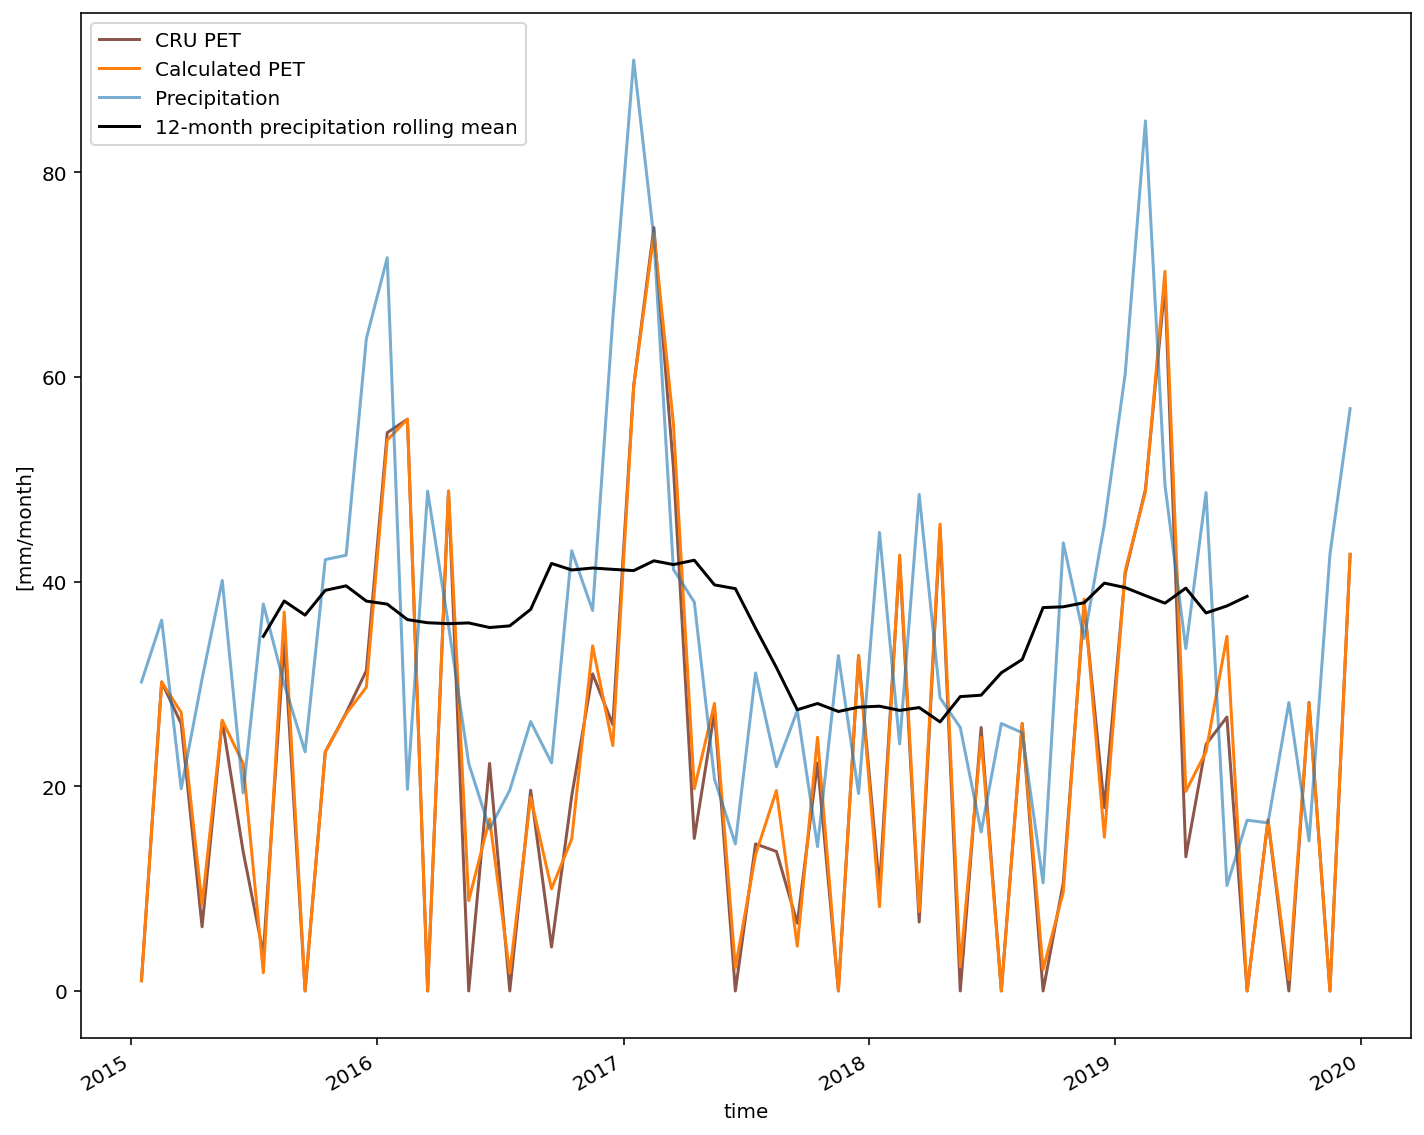

In [29]:

plt.figure(figsize=[10,8])
soil_moistureCRU.SM.plot(color = 'tab:brown', label = 'CRU PET')
soil_moistureCALC.SM.plot(color = 'tab:orange', label = 'Calculated PET')
pre_ds.sel(time=slice(*params['time'])).mean(['lon', 'lat'], keep_attrs = True).pre.plot(color = 'tab:blue', alpha = 0.6, label = 'Precipitation')
pre_ds.sel(time=slice(*params['time'])).pre.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(color = 'k', label = '12-month precipitation rolling mean')

plt.ylabel('[mm/month]')
plt.legend()

plt.tight_layout()



### Research Question 1: How much precipitation is needed to end a soil moisture drought? 

How am I defining soil moisture drought? To test how much precip is needed? 

### Research Question 2: And how does that change if temperature increases (but precip holds steady)?
Increase input temperature by +2


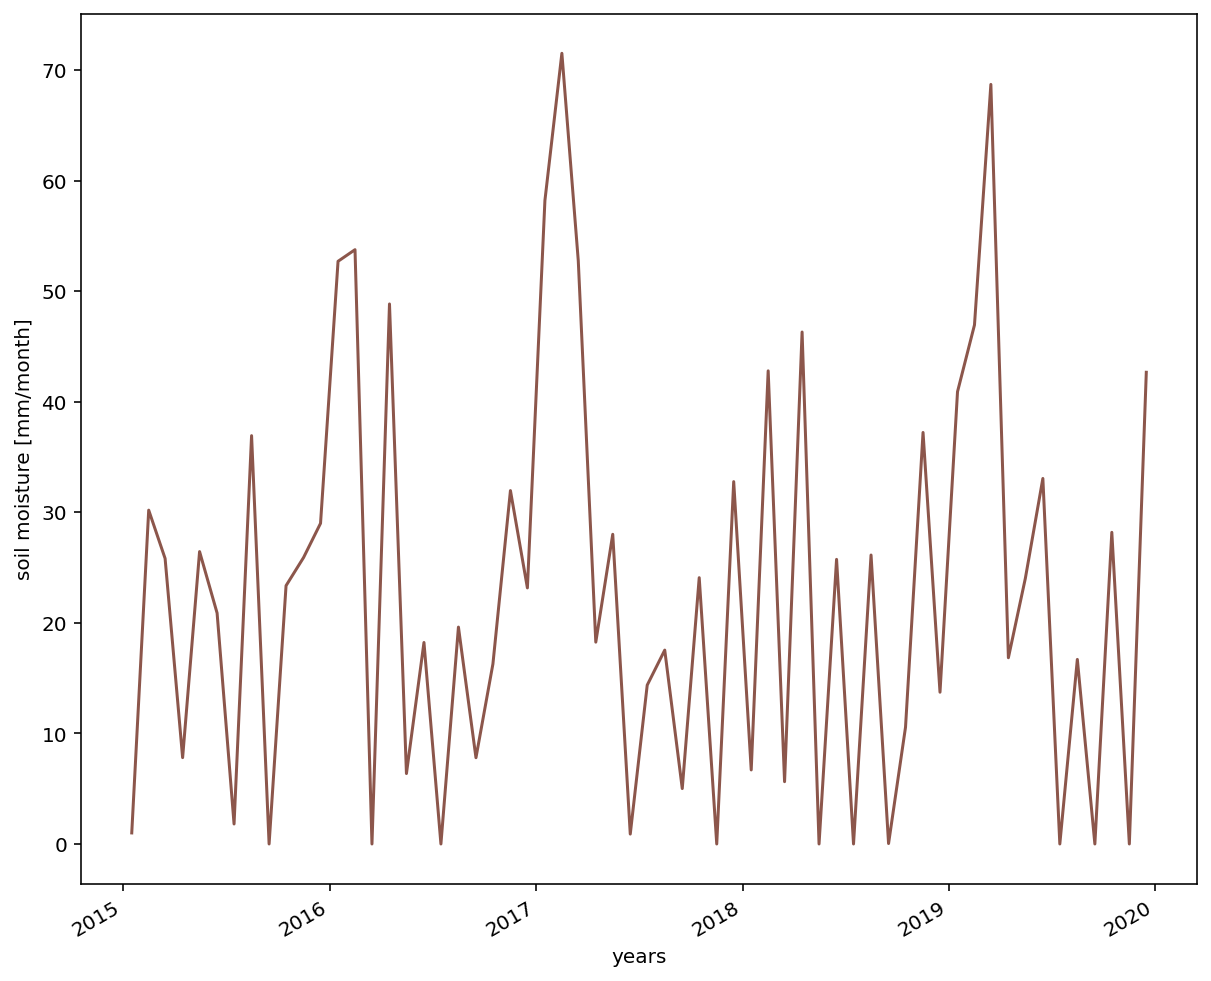

In [32]:
tmx = tmx_ds.mean(['lon', 'lat'], keep_attrs = True).tmx 
tmn = tmn_ds.mean(['lon', 'lat'], keep_attrs = True).tmn 

soil_moisture_tempUP = model.bucket_integration(CRUpet = False, date_ini = '2015-01', date_end = '2019-12', tmx = tmx+2, tmn = tmn+2)

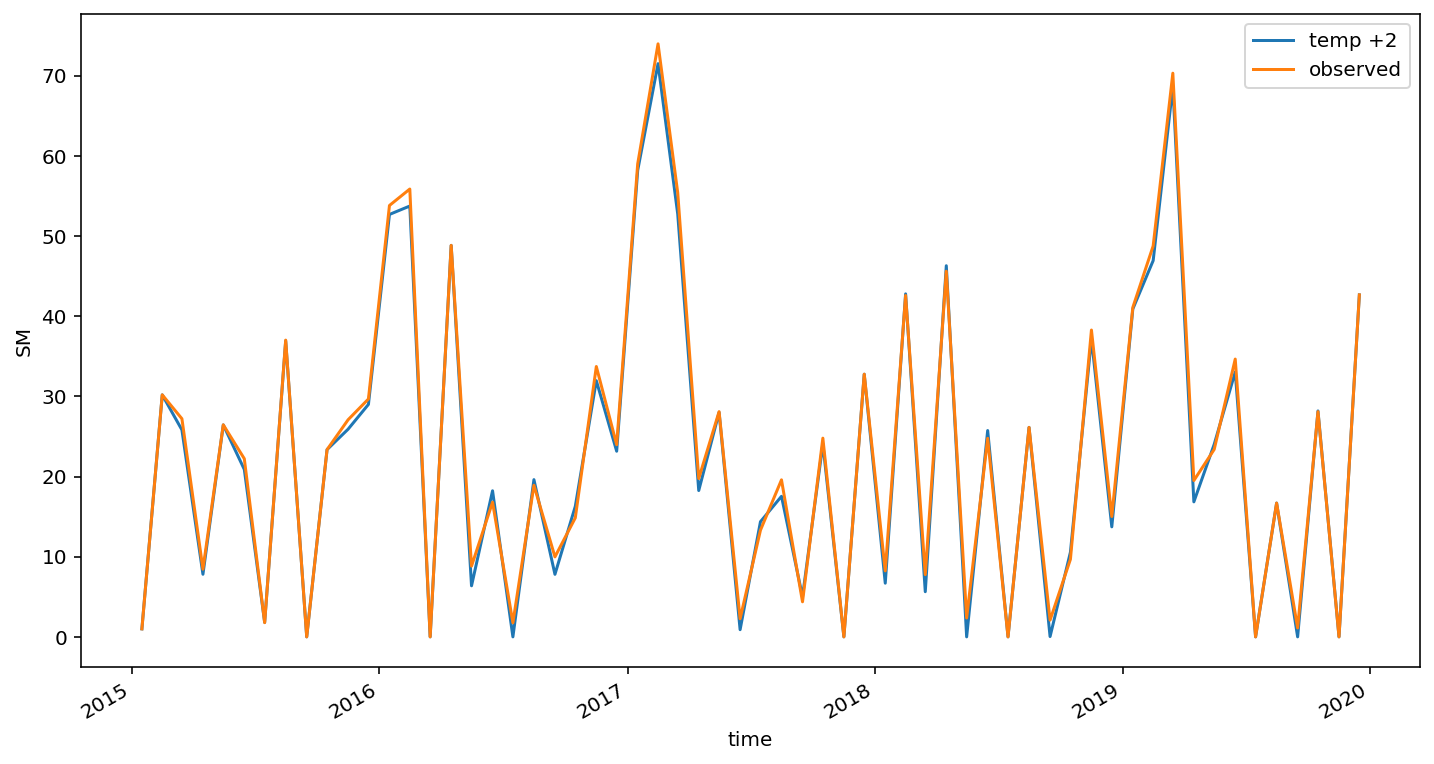

In [39]:
soil_moisture_tempUP.SM.plot(label = 'temp +2')
soil_moistureCALC.SM.plot(label = 'observed')
plt.legend()

### Research Question 3:  How sensitive is the model to the  extremeness of preciptation? 

In [ ]:
# model experiments
# create a dictionary to trial different inputs

In [ ]:
# dataframe 
# create a pandas dataframe for easy visualization of outputs and plotting

In [ ]:
SM = xr.Dataset({'time': (['time'],pre_ds.time)})
SM

In [ ]:
# OLD SORT OF WORKING MODEL FOR SAFEKEEPING

def bucket_integration(self, precipitation = pre_ds.mean(['lon', 'lat'], keep_attrs = True).pre, 
                           SM_ini = 1, time_ini = 0, 
                           time_end = 1000, time_offset = 0, tstep = 1, 
                           CRUpet = False,
                           crit = 150, wilt = 1 ): # need to figure out crit and wilt 
        """ governing equation 
        
        PARAMETERS:
        
        """
        
        self.precip = precipitation
        self.time_ini = time_ini
        self.time_end = time_end
        self.time_offset = time_offset
   
        self.tstep = tstep
    
        self.crit = crit
        self.wilt = wilt
        
        nsteps = int((time_end-time_ini)/tstep)
        self.time = np.arange(nsteps)
        SM = np.zeros(nsteps+1)
        SM[0] = SM_ini
        plottime = np.zeros(nsteps+1)
        
        for t in range(0, nsteps):
            thist = t * tstep
            plottime[t] = thist
        
            # bucket integration equation
            # with scaling (doesn't work yet)
            if CRUpet == False:
                SM[t+1] =  self.precip[t] - self.scaling_factor(SM[t]) * self.Epot(10, 2, 12)
                #SM[t+1] =  self.precip[t] - self.Epot(10, 2, 12)
            
            # with CRU EPOT data
            if CRUpet == True: 
                SM[t+1] =  self.precip[t] - self.scaling_factor(SM[t]) * self.pet[t]
                #SM[t+1] =  self.precip[t] - self.pet[t]
            
        self.time = plottime[0: nsteps]
        self.SM = SM[0: nsteps]
        self.plot_timeseries()
            
        return self.SM, self.time